In [ ]:
!apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop2.7.tgz
!tar -xvf spark-3.1.1-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop2.7"
import findspark
findspark.init()

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://security.ubuntu.com/ubuntu bionic-securi

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount = True)
%cd '/content/gdrive/MyDrive/LDS9_ BigData'

Mounted at /content/gdrive
/content/gdrive/MyDrive/LDS9_ BigData


In [ ]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from pyspark.sql.functions import when,count,col,isnan,isnull,concat,when

In [ ]:
spark = SparkSession \
  .builder \
  .master("local[*]")\
  .appName("New-Spark") \
  .config("spark.memory.fraction", 0.8) \
  .config("spark.executor.memory", "4g") \
  .config("spark.driver.memory", "4g")\
  .config("spark.sql.shuffle.partitions" , "800") \
  .config("spark.memory.offHeap.enabled",'true')\
  .config("spark.memory.offHeap.size","4g")\
  .getOrCreate()
spark

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.types import StringType, StructField, StructType, IntegerType
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import array,col, when, count, isnan, isnull, explode, lit

### Data Exploring

In [ ]:
df = pd.read_excel('/content/gdrive/MyDrive/LDS9_ BigData/data/womens-ecommerce-clothing-reviews/Womens_Clothing_E_Commerce_Reviews.xlsx',sheet_name='Reviews')

In [ ]:
df.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [ ]:
df.dtypes

Unnamed: 0                  int64
Clothing ID                 int64
Age                         int64
Title                      object
Review Text                object
Rating                      int64
Recommended IND             int64
Positive Feedback Count     int64
Division Name              object
Department Name            object
Class Name                 object
dtype: object

In [ ]:
dataSchema = StructType([
    StructField("Unnamed: 0", IntegerType(), nullable = True),
    StructField("Clothing ID", IntegerType(), nullable = True),
    StructField("Age", IntegerType(), nullable = True),
    StructField("Title", StringType(), nullable = True),
    StructField("Review Text", StringType(), nullable = True),
    StructField("Rating", IntegerType(), nullable = True),
    StructField("Recommended IND", IntegerType(), nullable = True),
    StructField("Positive Feedback Count", IntegerType(), nullable = True),
    StructField("Division Name", StringType(), nullable = True),
    StructField("Department Name", StringType(), nullable = True),
    StructField("Class Name", StringType(), nullable = True)])

In [ ]:
data = spark.createDataFrame(df,schema=dataSchema)

In [ ]:
data.printSchema()

root
 |-- Unnamed: 0: integer (nullable = true)
 |-- Clothing ID: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Title: string (nullable = true)
 |-- Review Text: string (nullable = true)
 |-- Rating: integer (nullable = true)
 |-- Recommended IND: integer (nullable = true)
 |-- Positive Feedback Count: integer (nullable = true)
 |-- Division Name: string (nullable = true)
 |-- Department Name: string (nullable = true)
 |-- Class Name: string (nullable = true)



Nhận xét: 


- Có 10 cột input bao gồm: *Unnamed: 0, Clothing ID, Age, Title, Review Text, Recommended IND, Positive Feedback Count, Division Name, Department Name, Class Name*
- Cột Target : *Rating*
- Các cột số: *Unnamed: 0, Clothing ID, Age, Recommended IND, Positive Feedback Count*
- Các cột chuỗi: *Title, Review Text,Division Name, Department Name, Class Name*
- Nhận thấy cột Unnamed:0 không liên quan đến dữ liệu nên tiến hành bỏ. 
- Cột Class Name là mô tả chi tiết của 2 cột Division Name và Department Name nên ta chỉ cần giữ lại cột Class Name 

In [ ]:
# Choose necessary columns
data = data.select('Age','Title','Review Text','Rating','Positive Feedback Count','Recommended IND','Class Name','Clothing ID')

## Data Cleaning

### Missing Values

In [ ]:
data.select([count(when(isnan(col),col)).alias(col) for col in data.columns]).toPandas()

,Age,Title,Review Text,Rating,Positive Feedback Count,Recommended IND,Class Name,Clothing ID
0,0,3810,845,0,0,0,14,0


In [ ]:
data.select([count(when(isnull(col),col)).alias(col) for col in data.columns]).toPandas()

,Age,Title,Review Text,Rating,Positive Feedback Count,Recommended IND,Class Name,Clothing ID
0,0,0,0,0,0,0,0,0


**Nhận xét :** 
Dữ liệu có 23481 dòng tuy nhiên cột *Title* có đến 3810 giá trị **Nan**. 

Trong khi cột *Review Text* cũng có tới 845 giá trị *Nan*, việc drop các giá trị *Nan* sẽ ảnh hưởng đến kết quả phân tích. 

**Giải pháp:**

- Đối với hàng mà cả *Title* và *Review Text* đều là Nan thì chỉ còn đánh giá rating là có giá trị. Ta tiến hành tạo cột *avg_rating* là trung bình rating cho mỗi *Clothing ID* sau đó ta có thể tiến hành bỏ những hàng này cũng như cột Clothing ID

- Sau đó, tiến hành merger nội dung cột *Title* và *Review Text* làm một để phân tích NLP.
 

In [ ]:
#tạo cột avg_rating
avg_rating = data.groupBy('Clothing ID').agg({'Rating':'avg'}).withColumnRenamed('avg(Rating)','avg_rating')
data = data.join(avg_rating,on='Clothing ID',how='inner',)
data.show(3)

+-----------+---+--------------------+--------------------+------+-----------------------+---------------+----------+----------+
|Clothing ID|Age|               Title|         Review Text|Rating|Positive Feedback Count|Recommended IND|Class Name|avg_rating|
+-----------+---+--------------------+--------------------+------+-----------------------+---------------+----------+----------+
|       1025| 38|                 NaN|The inseam is adv...|     4|                     10|              1|     Jeans|     4.464|
|       1025| 35|            Gorgeous|I love paige bran...|     5|                     14|              1|     Jeans|     4.464|
|       1025| 30|Not petite inseam...|I was excited to ...|     1|                      1|              0|     Jeans|     4.464|
+-----------+---+--------------------+--------------------+------+-----------------------+---------------+----------+----------+
only showing top 3 rows



In [ ]:

#Loại bỏ các cột cả Review Text và Title chứ Nan
print('Số cột trước khi xóa Nan ở 2 cột Review Text và Title:', data.count())
data = data.filter(~((col('Review Text') == 'NaN')&(col('Title') == 'NaN')))
print('Số cột sau khi xóa Nan ở 2 cột Review Text và Title :', data.count())

Số cột trước khi xóa Nan ở 2 cột Review Text và Title: 23481
Số cột sau khi xóa Nan ở 2 cột Review Text và Title : 22637


In [ ]:
#Drop cột Clothing ID
data = data.drop('Clothing ID')

In [ ]:
data = data.withColumn('Content',when(isnan(col('Title')) & ~isnan(col('Review Text')),col('Review Text')).
                               when(~isnan(col('Title')) & isnan(col('Review Text')),col('Title')).
                                    otherwise(concat(col('Title'),lit(' '),col('Review Text'))))
data.show(3)

+---+--------------------+--------------------+------+-----------------------+---------------+----------+----------+--------------------+
|Age|               Title|         Review Text|Rating|Positive Feedback Count|Recommended IND|Class Name|avg_rating|             Content|
+---+--------------------+--------------------+------+-----------------------+---------------+----------+----------+--------------------+
| 38|                 NaN|The inseam is adv...|     4|                     10|              1|     Jeans|     4.464|The inseam is adv...|
| 35|            Gorgeous|I love paige bran...|     5|                     14|              1|     Jeans|     4.464|Gorgeous I love p...|
| 30|Not petite inseam...|I was excited to ...|     1|                      1|              0|     Jeans|     4.464|Not petite inseam...|
+---+--------------------+--------------------+------+-----------------------+---------------+----------+----------+--------------------+
only showing top 3 rows



### Duplicate Values

In [ ]:
print('Number of duplicate row:',(data.count() - data.distinct().count()))

Number of duplicate row: 2


**Nhận xét:** 

Chỉ có 2 giá trị bị trùng nhau nên ta tiến hành bỏ

In [ ]:
data = data.drop_duplicates()

## Feature Engineering

### Numeric Columns:

In [ ]:
num_data = data.select('Age','Rating','Positive Feedback Count','Recommended IND','avg_rating').toPandas()

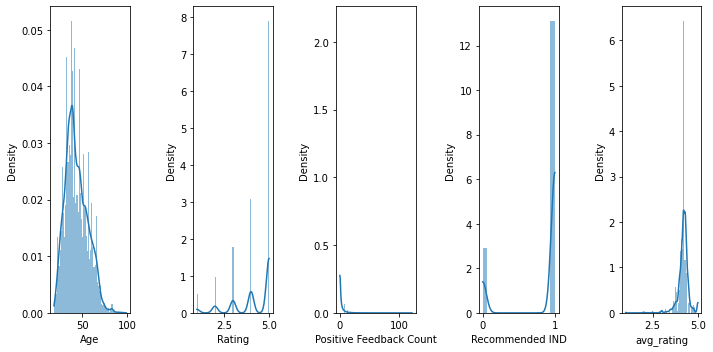

In [ ]:
plt.figure(figsize=(10,5))
for i , col in enumerate(num_data.columns):
  plt.subplot(1,5,i+1)
  sns.histplot(num_data[col],kde=True, stat="density", linewidth=0)
  plt.tight_layout()

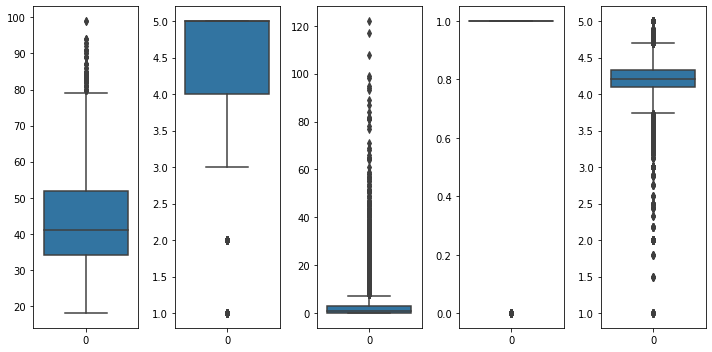

In [ ]:
plt.figure(figsize=(10,5))
for i , col in enumerate(num_data.columns):
  plt.subplot(1,5,i+1)
  sns.boxplot(data = num_data[col])
  plt.tight_layout()


**Nhận xét :**
- Các cột số có range khác biệt nhau lớn.
- Ngoài cột Age thì các cột còn lại đều có dạng phân phối không chuẩn. 
- Các cột đều có outlier với số lượng lớn
- Biểu đồ còn cho thấy giá trị Rating bị mất cân bằng khi đa số bình luận đánh giá là tích cực

=> Sử dụng Standard Scaler

In [ ]:
#Check correlation with Rating:
data.select('Age','Rating','Positive Feedback Count','Recommended IND','avg_rating','Rating').toPandas().corr()[['Rating']]

,Rating,Rating
Age,0.029891,0.029891
Rating,1.000000,1.000000
Positive Feedback Count,-0.060831,-0.060831
Recommended IND,0.792487,0.792487
avg_rating,0.287639,0.287639
Rating,1.000000,1.000000


**Nhận xét :**
- Cột *Age* và *Positive Feedback Count* cho thấy ít có sự tương quan với Target cần loại bỏ
- Cột *Recommended IND* có tương quan mạnh, giúp tăng khả năng dự đoán chính xác

In [ ]:
from pyspark.ml.feature import RobustScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vectors
from pyspark.ml import  Pipeline

In [ ]:
#num_assembler = VectorAssembler(inputCols=['Rating','Recommended IND','avg_rating'],outputCol='num_features')
#num_scaler = RobustScaler(inputCol='num_features',outputCol='scaled_num_features',withCentering=True)
#num_pipeline = Pipeline(stages=(num_assembler,num_scaler))

In [ ]:
for col in ['Rating','Recommended IND','avg_rating']:
    Q3 = np.quantile(data.select(col).toPandas(),.75)
    Q1 = np.quantile(data.select(col).toPandas(),.25)
    data = data.withColumn(col+'_scaled',(data[col]-Q1)/(Q3-Q1))

In [ ]:
 #data = num_pipeline.fit(data).transform(data)

In [ ]:
data.show(3,False)

+---+-------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------+-----------------------+---------------+----------+------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### String Column

In [ ]:
from pyspark.ml.feature import RegexTokenizer,StopWordsRemover,CountVectorizer,IDF,StringIndexer,OneHotEncoder
from pyspark.sql.functions import length,explode,col,collect_list,array_intersect

In [ ]:
tokenizer = RegexTokenizer(inputCol="Content", outputCol="token_text", pattern='[^A-Za-z0-9]+',gaps=True)
stopremove = StopWordsRemover(inputCol='token_text',outputCol='stop_tokens')
count_vec = CountVectorizer(inputCol='stop_tokens',outputCol='c_vec')
idf = IDF(inputCol="c_vec", outputCol="tf_idf")
indexer = StringIndexer(inputCol='Class Name',outputCol='class_name_idx')
onehot = OneHotEncoder(inputCol='class_name_idx',outputCol='class_name_1hot')

In [ ]:
data = data.withColumn('length',length(col('Content')))

In [ ]:
string_pipeline = Pipeline(stages=[tokenizer,stopremove,indexer,onehot])

In [ ]:
data=string_pipeline.fit(data).transform(data)

In [ ]:
data.show(1,False)

+---+-----+---------------------------------------------------------------+------+-----------------------+---------------+----------+----------+---------------------------------------------------------------+-------------+----------------------+------------------+------+--------------------------------------------------------------------------+------------------------------------------+--------------+---------------+
|Age|Title|Review Text                                                    |Rating|Positive Feedback Count|Recommended IND|Class Name|avg_rating|Content                                                        |Rating_scaled|Recommended IND_scaled|avg_rating_scaled |length|token_text                                                                |stop_tokens                               |class_name_idx|class_name_1hot|
+---+-----+---------------------------------------------------------------+------+-----------------------+---------------+----------+----------+--------------

In [ ]:
#Phân tích từ trong Content ở mỗi mức Rating. Sử dụng 50 keywords mỗi mức Rating để vẽ WordCloud

In [ ]:
from wordcloud import WordCloud, STOPWORDS

In [ ]:
key_words = []
for i in range(1,6):
  temp =  data.where(data['Rating'] == i).\
          select(explode('stop_tokens')).\
          groupby(col('col')).\
          count().\
          sort(col('count').desc())
  bag_words = temp.select('col').toPandas().col.tolist()
  key_words.append(bag_words)

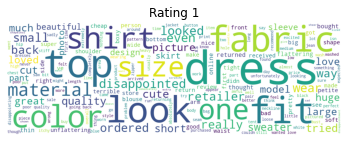

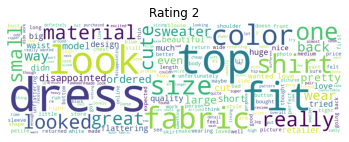

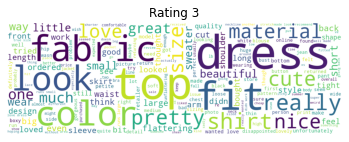

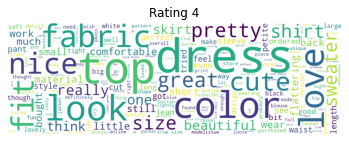

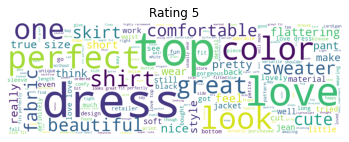

In [ ]:
for i in range(0,5):
  values_words = []
  content = data.where(data['Rating'] == i+1).\
            select(explode('stop_tokens')).\
            toPandas().col.tolist()
  for word in content:
    if word in key_words[i]:
      values_words.append(word)
    else:
      pass
  wordcloud = WordCloud(background_color = 'white', width = 1200, height = 400).generate(' '.join(values_words))
  plt.imshow(wordcloud)
  plt.title('Rating ' + np.str(i+1))
  plt.axis('off')
  plt.grid(False)
  plt.show()
  

**Nhận xét:**
Sau khi vẽ wordcloud cho 5 mức rating, ta thấy rằng nhiều từ được lặp đi lặp lại trong cả 5 mức khiến cho việc dự đoán qua text không hiệu quả. 

Tiến hành lọc bỏ những từ xuất hiện trong cả 5 nhóm. 

In [ ]:
negative_words = [item for sublist in key_words[:3] for item in sublist] #Negative với Rating 1-2
positive_words = [item for sublist in key_words[4:] for item in sublist] #Positive với Rating 3-4
intersection_words = set(negative_words).intersection(positive_words)

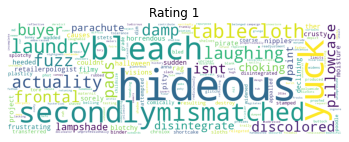

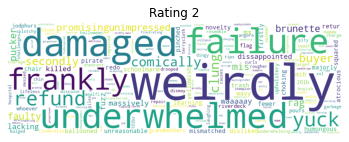

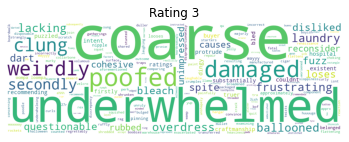

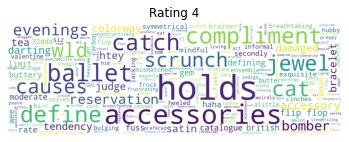

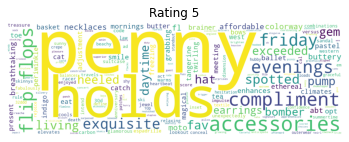

In [ ]:
best_words = []
for i in range(0,5):
  values_words = []
  content = data.where(data['Rating'] == i+1).\
            select(explode('stop_tokens')).\
            toPandas().col.tolist()
  for word in content:
    if (word in key_words[i]) & (word not in intersection_words):
      values_words.append(word)
    else:
      pass
  best_words.append(values_words)
  wordcloud = WordCloud(background_color = 'white', width = 1200, height = 400).generate(' '.join(values_words))
  plt.imshow(wordcloud)
  plt.title('Rating ' + np.str(i+1))
  plt.axis('off')
  plt.grid(False)
  plt.show()

**Nhận xét:**
Với việc lọc đi những từ có trong list những từ xuất hiện ở tất cả hạng Rating ta đã có kết quả chấp nhận được với các keywords phù hợp cho việc dự đoán.

In [ ]:
#Tạo dataframe những từ đại diện cho mỗi nhóm Rating 
list_best_words = []
for i in range(5):
  list_best_words.append([i+1,best_words[i]])
df_best_words = pd.DataFrame(list_best_words,columns=['Rating','present_words'])
df_best_words = spark.createDataFrame(df_best_words)

In [ ]:
#Add cột present_words cho mục đích lọc trong data
data = data.join(df_best_words,on='Rating')

In [ ]:
#Lọc các từ vừa nằm trong stop_tokens và vừa nằm trong present_words
data = data.withColumn('filter_words',array_intersect(col('stop_tokens'),col('present_words')))

In [ ]:
count_vec = CountVectorizer(inputCol='filter_words',outputCol='c_vec')
idf = IDF(inputCol="c_vec", outputCol="tf_idf")
pipe_line = Pipeline(stages=[count_vec,idf])

In [ ]:
clean_data = pipe_line.fit(data).transform(data)

##Train - Test models

### Split data

In [ ]:
#assembler = VectorAssembler(inputCols=['tf_idf','length','class_name_1hot','Recommended IND_scaled','avg_rating_scaled'],outputCol='features')
assembler = VectorAssembler(inputCols=['tf_idf','length'],outputCol='features')

In [ ]:
final_data = assembler.transform(clean_data)

In [ ]:
(train_set,test_set) = final_data.randomSplit((0.8,0.2))

###Train models with Text Only

In [ ]:
from pyspark.ml.classification import NaiveBayes, RandomForestClassifier, LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [ ]:
nb = NaiveBayes(labelCol='Rating')
lg = LogisticRegression(labelCol='Rating')
rf = RandomForestClassifier(labelCol="Rating")

In [ ]:
predictor_nb = nb.fit(train_set)
predictor_lg = lg.fit(train_set)
predictor_rf = rf.fit(train_set)

In [ ]:
test_results_nb = predictor_nb.transform(test_set)
test_results_lg = predictor_lg.transform(test_set)
test_results_rf = predictor_rf.transform(test_set)

In [ ]:
acc_eval = MulticlassClassificationEvaluator(labelCol='Rating')
acc_nb = acc_eval.evaluate(test_results_nb)
acc_lg = acc_eval.evaluate(test_results_lg)
acc_rf = acc_eval.evaluate(test_results_rf)

In [ ]:
print('Accuracy of Naive Bayes model: ',acc_nb)
print('Accuracy of Logistic Regression model: ',acc_lg)
print('Accuracy of Random Forest model: ',acc_rf)

Accuracy of Naive Bayes model:  0.08823243826064618
Accuracy of Logistic Regression model:  0.45174545495210344
Accuracy of Random Forest model:  0.394805274530047


**Nhận xét:**
- Các model chỉ dựa trên text đều đưa ra kết quả rất kém khi chưa đạt đến 50% một số lí do có thể được giải thích như sau:
  - Dữ liệu bị mất cân bằng
  - Data chưa đủ mạnh để thuật toán có đủ function để predict.
  - Cần thêm vào các numeric feature nhằm cải thiện kết quả predict

### Re - sampling

In [ ]:
Rating = final_data.select('Rating').toPandas()

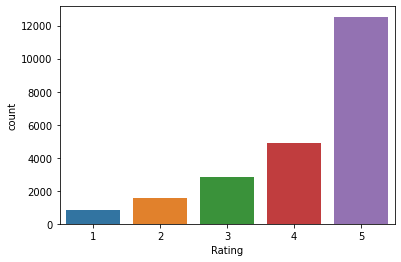

In [ ]:
sns.countplot(data = Rating,x='Rating');

**Nhận xét:**
- Đánh giá với thang 5 chiếm số lượng lớn dẫn đến dữ liệu bị mất cân bằng và thiếu chính xác trong việc dự đoán của model.

**Giải pháp:**
- Lấy cột rating 5 làm chuẩn để over-sampling các giá trị của các thang đó khác. 

In [ ]:
ratio_list = []
for i in range(1,5):
  ratio = int(final_data.filter(col('Rating') == 5).count()/final_data.filter(col('Rating') == i).count())
  ratio_list.append(ratio)
ratio_list 

[15, 8, 4, 2]

In [ ]:
combined_df = final_data.filter(col('Rating')==5)
for i in range(1,5):
  rating_df = final_data.filter(col('Rating') == i)
  ratio_ = range(ratio_list[i-1])
  oversample_df = rating_df.withColumn('dummy',explode(array([lit(x) for x in ratio_]))).drop('dummy')
  combined_df = combined_df.unionAll(oversample_df)


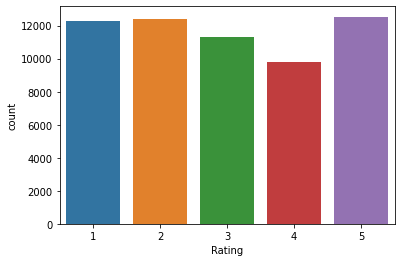

In [ ]:
sns.countplot(data = combined_df.select('Rating').toPandas(),x='Rating');

**Nhận xét:** Dữ liệu đã được re-sampling khá cân bằng giữa các thang đo. Ta tiến hành re-train.

In [ ]:
(train_set,test_set) = combined_df.randomSplit((0.8,0.2))

In [ ]:
predictor_nb = nb.fit(train_set)
predictor_lg = lg.fit(train_set)
predictor_rf = rf.fit(train_set)

In [ ]:
test_results_nb = predictor_nb.transform(test_set)
test_results_lg = predictor_lg.transform(test_set)
test_results_rf = predictor_rf.transform(test_set)

In [ ]:
acc_nb = acc_eval.evaluate(test_results_nb)
acc_lg = acc_eval.evaluate(test_results_lg)
acc_rf = acc_eval.evaluate(test_results_rf)

In [ ]:
print('Accuracy of Naive Bayes model: ',acc_nb)
print('Accuracy of Logistic Regression model: ',acc_lg)
print('Accuracy of Random Forest model: ',acc_rf)

Accuracy of Naive Bayes model:  0.08994439895447884
Accuracy of Logistic Regression model:  0.49139009420467183
Accuracy of Random Forest model:  0.12468382297914248


**Nhận xét:**
Việc cân bằng lại dữ liệu đã giúp cải thiện được các models tuy nhiên độ chính xác vẫn còn thấp để giải quyết bài toán. 

**Giải pháp:**
Tăng cường độ mạnh của model bằng các features khác.

### Kết hợp các feature khác:

In [ ]:
assembler_multi_feats = VectorAssembler(inputCols=['tf_idf','length','avg_rating','class_name_1hot','Recommended IND'],outputCol='features')

In [ ]:
final_multi = assembler_multi_feats.transform(clean_data)

In [ ]:
(train_set,test_set) = final_multi.randomSplit((0.8,0.2))

In [ ]:
predictor_lg = lg.fit(train_set)

In [ ]:
test_results_lg = predictor_lg.transform(test_set)

In [ ]:
acc_lg = acc_eval.evaluate(test_results_lg)

In [ ]:
print('Accuracy of Logistic Regression model: ',acc_lg)

Accuracy of Logistic Regression model:  0.5443565031292004


**Kết luận :**
Việc sử dụng các thuộc tính khác giúp cải thiện mô hình với độ chính xác tăng từ 49% lên 54%.


Tuy nhiên, mô hình nhìn chung vẫn chưa thể sử dụng để dự đoán được Rating với chỉ hơn 50% độ chính xác.


Bài toán cần thu thập thêm dữ liệu cũng như các feature khác để có thể tăng độ chính xác của thuật toán hoặc chuyển cách giải quyết bài toán về dạng dự đoán sentiment like/dislike để tăng độ chính xác.